# Expectation Maximization with Gaussian Mixture Models

## William Koehrsen wjk68

# Introduction

In this notebook we will explore using the expectation maximization algorithm in order to separate data generated from multiple Gaussian distributions. We will concentrate on artificially generated two-dimensional data so we can visualize the results of our algorithms, but the Expectation Maximization model developed is generalizable to higher dimensions. Our model will be built on the assumption that the generating distribution for the data is Gaussian hence the name Gaussian mixture models. A Gaussian is completely defined by the mean (location) $\mu$ and the covariance matrix (spread) $\sigma$ and using these parameters, we can find the posterior probability that a given data point is from a specific distribution which allows us to make soft classifications of observations.

## Soft Classification

For classification problems, we are looking to separate data points into different clusters (groupings) based on some measure of similarity. There are numerous methods for doing this which fall into 2 categories: hard and soft classification. In a hard classification, such as that arrived at in K-Means clustering, a data point can belong to only a single cluster. In contrast, for a soft classification, we specify a probability that a data point is from a given cluster. This lets us represent uncertainty about our classification. With the expectation-maximization algorithm, we can calculate a posterior probability that a given data point is from a specific cluster given the values of the data and the parameters (weights, means, and covariances) of the underlying distributions. In this notebook we will look at making soft classifications of data points based on a Gaussian mixture model and applying the expectation maximization algorithm.

In [1]:
# Numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Change default size of text on plots
import matplotlib
matplotlib.rcParams['font.size'] = 18

import matplotlib.mlab as mlab

# Multivariate normal for finding likelihoods of data given a distribution
from scipy.stats import multivariate_normal

# Metric: Log Likelihood

In order to assess the "goodness" of our classifications, we need a metric which in the case of a Gaussian mixture model is the log likelihood of the data given the Gaussian distributions. This lets us know if we should continue iterations of the EM algorithm or if we have reached a maximum likelihood for the data. 

The log likelihood for a mixture of Gaussians is the probability of observing a set of data under particular values of the parameters (weights, means, and covariances) for the Gaussians. This is used to assess covergence of EM: the algorithm continues until the log likelihood of the data stops increasing at some specified rate. 

In [2]:
# Compute the log(sum_i exp(Z_i)) for an array Z
def log_sum_exp(Z):
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

# Compute the loglikelihood of data for a Gaussian Mixture Model
# with the specified weights, means, and covariances
def loglikelihood(data, weights, means, covs):
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    
    # The log likelihood is summed over all the data points
    for d in data:
        Z = np.zeros(num_clusters)
        # There is a contribution to the log likelihood for every cluster for every data point
        for k in range(num_clusters):
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))

            # Log likelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2 * (num_dim * np.log(2 * np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)

        # Increase log likelihood by data point across all clusters
        ll += log_sum_exp(Z)
            
    return ll

# Expectation-Step: Assign Cluster Responsibilities

The E step of the Expectation Maximization algorithm assigns responsibilities of data points to clusters based on the parameters (means and covariances) of the clusters. The responsibilities are fractions between 0 and 1, and for a single data point, the responsibilities sum to 1. We will denote $r_{ik}$ as the responsibility of data point $i$ to cluster $k$. In contrast to hard classification methods, each data point can belong to multiple clusters which allows us to represent uncertainty about classifiction predictions.

For a given data point, the responsibility summed over all clusters must equal 1:

$$r_{i1} + r_{i2} + \ldots + r_{ik} = 1$$

The responsilibity of a particular cluster for a data point is the probability the data point comes from that cluster given the data point and the cluster parameters. We can express this in terms of Bayes Rule:

$$r_{ik} = p(C_k | i) = \frac{p(i | C_k)p(C_k)}{p(i)}$$

To determine unnormalized cluster responsibilities, we need to take the likelihood of the data point under the cluster parameters multiplied by the weight of the cluster, $\pi_k$. This is the numerator in Bayes Theorem and is expressed as:

$$r_{ik} \propto \pi_k N(x_i | \mu_k, \Sigma_k)$$

With $N(x_i | \mu_k, \Sigma_k)$ the Gaussian distribution of cluster $k$ with mean $\mu_k$ and covariance $\Sigma_k$.

We can normalize the responsibiliy by dividing by the normalization constant, which for data point $i$ is the sum over the clusters of the likelihoods of the data point in that cluster times the cluster weight.

$$r_{ik} = \frac{\pi_k N(x_i | \mu_k, \Sigma_k)}
{\sum_{k=1}^{K} \pi_k N(x_i | \mu_k, \Sigma_k)}$$

The final value of $r_{ik}$ must be between 0 and 1 and represents the responsibility of cluster $k$ for data point $i$ given the mean and covariance of the cluster. 

To compute the likelihood of drawing a data point from a Guassian distribution, we can use the SciPy function
`multivariate_normal.pdf(x, mean, cov)`

This returns the likelihood of observing a data point, $x$, given the Gaussian distribution defined by the mean and covariance.

In [3]:
# Calculate all the responsibilities for the data points
# under the specified Gaussian distributions
# Responsibility is the weight of the cluster times the likelihood
# of the data point under the cluster parameters
def compute_responsibilities(data, weights, means, covs):
    num_data = len(data)
    num_clusters = len(means)
    
    resps = np.zeros((num_data, num_clusters))
    
    # Iterate through each data point
    for i in range(num_data):
        # Iterate through each cluster
        for k in range(num_clusters):
            # Responsibility of cluster k for data point i
            resps[i, k] = weights[k] * multivariate_normal.pdf(data[i], means[k], covs[k])
      
    # Calculate total responsibility for each data point
    row_sums = resps.sum(axis=1)[:, np.newaxis]
    
    # Normalize the responsibilities by the sum
    resps = resps / row_sums
    
    return resps

# Maximization Step: Update the Parameters of the Gaussian Distributions

Once the data point responsibilities have been assigned, the Gaussian distribution parameters must be updated to reflect the assignments of the data points. There are three parameters that must be calculated during the maximization step: the cluster weights $\hat{\pi}_k$, the cluster means, $\hat{\mu}_k$, and the cluster covariance matrices, $\hat{\Sigma}_k$.
The weights, means, and covariances are calculated for each of the Gaussians based upon the data points and their responsibilities. This step is called the maximization step because we are maximizing the likelihood of the data points by adjusting the Gaussian distributions to match the data assignments. 

## Cluster Soft Counts

The first step is to compute the soft counts for the clusters: this is the sum of all the responsibilities for a given cluster.

$$N^{\text{soft}}_k = r_{1k} + r_{2k} + \ldots + r_{Nk} = \sum_{i=1}^{N} r_{ik}$$

Each cluster will have at least some fractional responsibility for every data point. This is different from K-means, where each data point is assigned to only one cluster. 

In [4]:
# Sums the responsibilities for a given cluster
def compute_soft_counts(resps):
    return np.sum(resps, axis=0)

## Cluster Weights

The cluster weights give a measure of how much each cluster is represented across the entire data set. The weight for a cluster $k$ is represented by $\hat{\pi}_k$. The cluster weight is the ratio of the soft count for that cluster $N^{\text{soft}}_k$ to the sum over the soft counts of all clusters. The sum of all soft counts is equivalent to the total number of data points.

$$\hat{\pi}_k = \frac{N^{\text{soft}}_k}{N}$$

The cluster weight serves as the prior for the cluster. With no other information, the posterior probability that a data point is from a cluster would collapse to the prior probability. In other words, if we had no information about the cluster parameters, we could still assign responsibilities based on the cluster weights. If one cluster is responsible for more data points, that will be reflected by a greater cluster weight.

In [5]:
# Calculate cluster weights
# The weight for a cluster is the soft count of the cluster
# divided by the total soft counts
def compute_weights(counts):
    num_clusters = len(counts)
    weights = np.zeros(num_clusters)
    
    # Calculate weight for each cluster
    for k in range(num_clusters):
        weights[k] = counts[k] / np.sum(counts)
        
    return weights

# Update Means of Gaussians

The first parameters, the weights of the distributions, $\hat{\pi}_k$ have been calculated. The next parameter is the mean of the Gaussian distribution, $\hat{\mu}_k$. 

The mean of a cluster is the weighted average of all data points divided by the soft count of the cluster. The weighted average of a data point is the coordinates of the data point multiplied by the responsibility of the cluster for that data point. The following equation calculates the new coordinates of the mean of cluster $k$.

$$\hat{\mu}_k = \frac{1}{N^{\text{soft}}_k} \sum_{i=1}^{N} r_{ik}x_i$$

We see that the final cluster mean is a weighted average over all the data points, unlike in K-Means, where the new means are calculated based only on the data points assigned to a cluster. The update step for the mean is repeated for each Gaussian distribution to find the new means of all the clusters. 

In [6]:
def compute_means(data, resps, counts):
    num_clusters = len(counts)
    num_data = len(data)
    
    means = [np.zeros(len(data[0]))] * num_clusters
    
    # For each cluster, calculate the new location of the mean
    for k in range(num_clusters):
        weighted_sum = 0.
        
        # Iterate over all data points
        for i in range(num_data):
            # Weighted sum is the responsibility times the coordinates of the point
            weighted_sum += resps[i, k] * data[i]
           
        # Multiply the weighted value by 1 / soft count for the cluster
        means[k] = weighted_sum * 1 / counts[k]
        
    return means

# Update Covariances

The third and final parameter to update in the Maximization step is the covariance matrix of the Gaussian distribution. The covariance matrix, like the means, is also a weighted average. In this case, it is the outer product summed over all data points weighted by the cluster responsibility for each data point. The final value of the covariance is then normalized using the soft count for the cluster. The outer product for the covariance is the matrix product of the difference between the data point and the cluster mean:

$$(x_i - \hat{\mu}_k)(x_i - \hat{\mu}_k)^T$$

Where $(x_i - \hat{\mu}_k)$ is a $d \times 1$ column vector and $(x_i - \hat{\mu}_k)^T$ is a $1 \times d$ row vector. The result of the multiplication is a $d \times d$ covariance matrix. For a 2-dimensional data set, the covariance matrix has the form:

$$\Sigma = \left( \begin{array}{cc}
\sigma_{x}^2 & \sigma_{xy}^2 \\
\sigma_{xy}^2 & \sigma_{y}^2 \\
 \end{array} \right) $$
 
The covariance matrix can only be calculated _after_ the means for the clusters have been determined. 

In [7]:
# Compute new covariances given the data, the responsibilities
# of each cluster for each data point, the calculated soft counts, and the calculated means
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim, num_dim))] * num_clusters
    
    # Iterate through all clusters
    for k in range(num_clusters):
        weighted_sum = np.zeros((num_dim, num_dim))
        
        # Iterate through all data points
        for i in range(num_data):
            # Compute the contribution to the covariance matrix of the data point
            weighted_sum += resp[i, k] * np.outer((data[i] - means[k]), (data[i] - means[k]).T)
            
        # To normalize the covariances, divide by the soft count of the cluster
        covariances[k] = weighted_sum / counts[k]
        
    return covariances

# Complete Expectation Maximization Algorithm

The final step is to put all of the code together. Given initial parameter estimates, we

1. Expectation: assign responsibilities for each data point to each cluster, $r_{ik}$
2. Maximization: calculate new parameters for the distributions given the responsibilities: $\hat{\pi}_k$, $\hat{\mu}_k$, $\hat{\Sigma}_k$
3. Determine log likelihood of data with the new distributions
4. Repeat steps 1-3 until log likelihood is no longer increasing at specified rate or until the maximum number of iterations is reached. 

All of this can be encapsulated in one overall function with the helper functions developed previously. The main part of the function is a loop that continues until the maximum number of iterations is reached or the increase in the log likelihood is below a specified threshold.

In [8]:
def EM_algorithm(data, init_means, init_covariances, init_weights, maxiter = 1000, thresh = 1e-4):
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print('Iteration %d' % it)
        
        # Expectation Step
        # Assign responsibilities to data points for each cluster
        resp = compute_responsibilities(data, weights, means, covariances)
        
        # Maximization Step
        # Calculate new parameters based on responsibilities and data
        counts = compute_soft_counts(resp)
        weights = compute_weights(counts)
        means = compute_means(data, resp, counts)
        covariances = compute_covariances(data, resp, counts, means)
        
        ll_next = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_next)
        
        if (ll_next - ll < thresh) and (ll_next > -np.inf):
            break
        ll = ll_next
    
    out = {'weights': weights, 'means': means, 'covs': covariances,
           'loglike': ll_trace, 'resp': resp}
    
    return out

## Generate Testing Data

We now need to define a function which can generate observations from a mixture of Gaussians. This function will take in a desired number of data points, initial means, initial covariances, and initial weights and will return a data set. The data points are randomly generated from the specified Gaussians which means that we know the correct parameters of the generation distributions. 

Using the data, we can run the expectation maximization algorithm and compare the resulting means, covariances, and weights to those we passed into the function (which serve as the "ground truth"). We can also visualize the data and the final Gaussian mixtures to determine how well the algorithm is able to separate the data points.

In [9]:
# Generate a number of data points from the specified mixture of Gaussians
# These data will serve as testing observations for the EM algoritm
def generate_data(num_data, means, covariances, weights):
    num_clusters = len(weights)
    data = []
    
    for i in range(num_data):
        # Randomly select one of the distributions to generate the data from
        k = np.random.choice(num_clusters, 1, p = weights)[0]
        
        # Generate the data given the mean and covariance matrix of the distribution
        x = np.random.multivariate_normal(means[k], covariances[k])
        
        data.append(x)
        
    return np.array(data)

# Two Clusters of Gaussian Data

We will start off by generating data from two Gaussian clusters that are well separated. The initial weights will be spread evenly among the two clusters. 

In [10]:
init_means = [
    [5, 4],
    [8, 7]
]

init_covariances = [
    [[0.35, 0.23], [0.23, 0.35]],
    [[0.1, 0.42], [0.42, 0.1]]
]

init_weights = [0.5, 0.5]

np.random.seed(10)
two_clusters_data = generate_data(100, init_means, init_covariances, init_weights)

## Visualize Generated Data

In [11]:
def plot_data(data):
    plt.figure(figsize=(8, 6))
    p = plt.scatter(data[:, 0], data[:, 1], c = 'navy', marker = 'o')
    return p

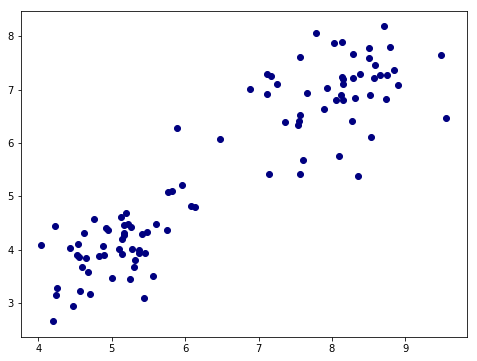

In [12]:
p = plot_data(two_clusters_data);

We see that the generated data are fairly separated into two distinct clusters. These distributions should be relatively easy for the algorithm to separate into the respective distributions. 

## Run Expectation Maximization Algorithm on Two Clusters Data

To initialize the algorithm, we will select two random data points as the Gaussian means, the covariance of the data will be the initial covariance, and the initial weights will be uniform for the clusters. The initial covariance is clearly an overestimate because we are using the covariance of the entire dataset and not each individual distribution, but hopefully the algorithm will still converge in reasonable time. 

In [13]:
np.random.seed(10)

# Initialize the parameters and run EM
def initialize_and_run(data, n_cluster):
    # Select two random points as starting means
    selected = np.random.choice(len(data), n_cluster, replace = False)
    initial_means = [data[i] for i in selected]
    
    # The initial covariances will be the covariance of the entire dataset
    initial_covs = [np.cov(data, rowvar=0)] * n_cluster
    
    # Equal initial weights
    initial_weights = [1./n_cluster] * n_cluster
    
    initial = {'data': data, 'weights': initial_weights,
               'means': initial_means, 'covs': initial_covs}
    
    # Run the algorithm with initial parameters
    results = EM_algorithm(data, initial_means, initial_covs, initial_weights)
    
    return initial, results
    
initial, results = initialize_and_run(two_clusters_data, 2)

Iteration 0
Iteration 5
Iteration 10
Iteration 15


## Visualize Results for 2 Clusters

The results returned by the algorithm are in dictionary form with the following entries:

* weights: the final distribution weights
* means: the final means of the Guassians
* covs: the final covariances of the Gaussians
* loglike: a trace of the log-likelihood of the data over the course of the algorith,
* resp: the final responsility of each Gaussian distribution for each data point

We can show the initial parameters and the final parameters on top of the data to demonstrate the effectiveness of the algorithm. The trace of the log likelihood is also plotted to show how the data gets "more likely" as the algorithm runs. 

In [14]:
# Plot the log likelihood trace.
# Plot the data points with the initial parameters
# Plot the data points with the final parameters after EM algorith,
def plot_results(initial, results):
    data = initial['data']
    
    plt.figure(figsize = (6, 4))
    plt.plot(results['loglike'], 'bo-')
    plt.xlabel('Iteration'); plt.ylabel('Log Likelihood')
    plt.title('Trace of Log Likelihood'); plt.show();
    
    delta = 0.2
    x = np.arange(np.min(data[:, 0]), np.max(data[:, 0]), delta)
    y = np.arange(np.min(data[:, 1]), np.max(data[:, 1]), delta)
    X, Y = np.meshgrid(x, y)
    
    col = ['green', 'red', 'magenta']
    
    initial_data = True
    # Plot the initial estimates and then the final results
    for d in [initial, results]:
        plt.figure(figsize = (8, 6))
        plt.plot(data[:, 0], data[:, 1], 'ko')
        
        # Iterate through the Gaussians
        for k in range(len(d['means'])):
            
            # Extract information
            mean = d['means'][k]
            cov = d['covs'][k]
            
            # Find the parameters of the standard deviations
            sigmax = np.sqrt(cov[0][0])
            sigmay = np.sqrt(cov[1][1])
            sigmaxy = cov[0][1]
            
            # Generate the bivariate normal from the standard deviations
            Z = mlab.bivariate_normal(X, Y, sigmax, sigmay,
                                     mean[0], mean[1], sigmaxy)
    
            plt.contour(X, Y, Z, 3, colors = col[k])
         
        # Add the correct title
        if initial_data:
            plt.title('Initial Estimates')
            initial_data = False
            plt.show()
        else:
            plt.title('Final Results')
            plt.show()
            
        

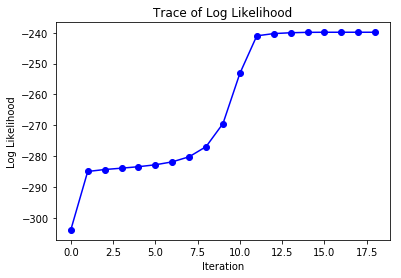

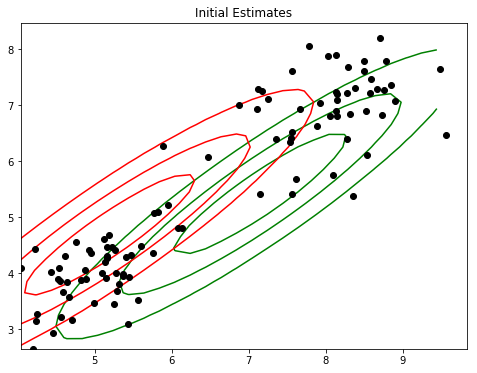

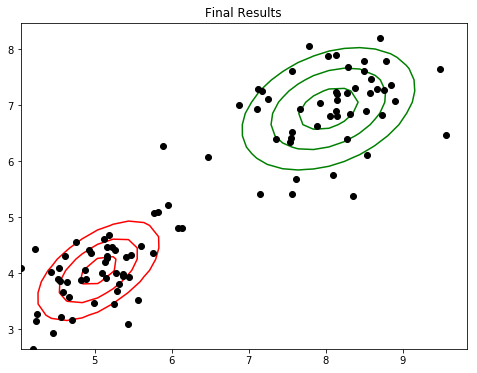

In [15]:
plot_results(initial, results)

We can see that the algorithm arrives at a very reasonable separation of the data. The initial variance was too high as expected, but the final result of the algorithm shows a smaller variance. 

# Test with 3 Clusters

We can repeat the same process but this time with 3 clusters and an uneven weighting of the distributions. The process to generate the data is the same as before as is the inialization and running of the algorithm.

In [16]:
# Specify initial parameters of data
init_means = [
    [1.5, 6],
    [7.9, 4.3],
    [15.3, 5.4]
]

init_covariances = [
    [[0.4, 0.1], [0.1, 0.5]],
    [[0.18, 0.5], [0.5, 0.12]],
    [[0.33, 0.35], [0.35, 0.4]]
]

init_weights = [0.25, 0.5, 0.25]

three_clusters_data = generate_data(180, init_means, init_covariances, init_weights)

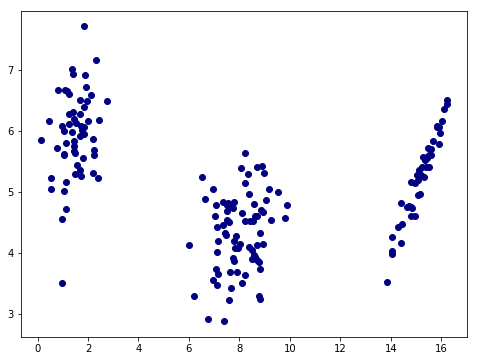

In [17]:
plot_data(three_clusters_data);

## Run Algorithm on 3 Clusters

In [18]:
initial, results= initialize_and_run(three_clusters_data, 3)

Iteration 0
Iteration 5


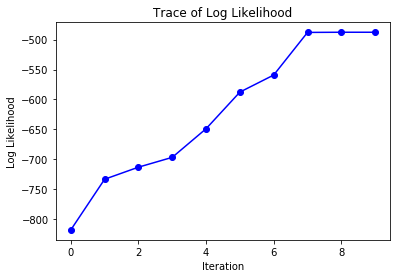

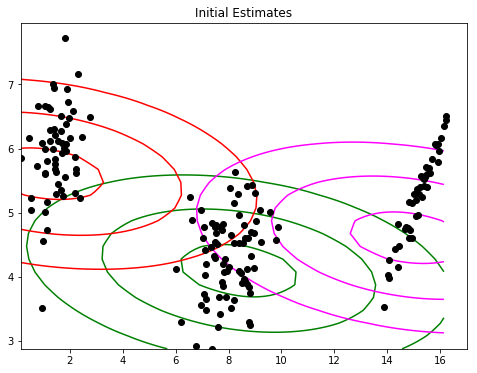

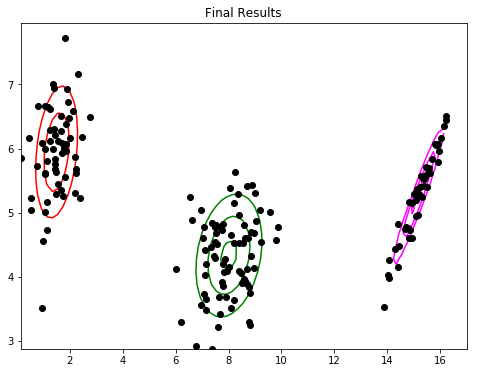

In [19]:
plot_results(initial, results)

With three clusters the results are still very good. The Expectation Maximization algorithm is able to determine the underlying Gaussian distributions that generated the data. Granted, the clusters were well separated and the algorithm would likely not perform as well if given data that was more mixed. We will test this in the next notebook where we look at clustering the MNIST digits using principal components and the Expectation Maximization algorithm.

# Conclusions

In this notebook we looked at how to soft classify data point using a Gaussian mixture model and the expectation maximization algorithm. Soft classification allows us to assign fractional responsibilities to data points for each cluster rather than strict class assignments. These fractional assignments show that there is some amount of uncertainty in the classifications. For many real-world problems, a data point might belong to multiple classes, such as in document topic classification, and Gaussian mixture models give us the framework for classifying data points in multiple categories. 

The expectation maximization algorithm works based on two steps: the expectation step involves assigning a responsibility of each cluster to each data point based on the current cluster (Gaussian) parameters. The maximization step then updates the parameters of each distribution based on the responsibilities and the data. For Gaussians, this means we find new cluster weights (representing the total responsibility of the cluster for all the data points), the mean of the distribution, and the covariance of the distribution. After finding the new cluster parameters, we calculate the log likelihood of the data given the distributions. This iterative process of assignment and updating of parameters continues until the log likelihood no longer increases above a specified threshold, or until the maximum number of iterations is reached. At this point, the algorithm breaks out of the iterations and returns the final weights, means, and covariances for the distributions. The expectation maximization algorithm therefore finds the parameters of the Gaussian distributions that maximize the likelihood of the data.

As shown in this notebook, the EM algorithm works very well for distinct clusters. When the data is generated from Gaussians that are well-separated, the algorithm is able to successfully identify the clusters if it is provided with the number of clusters. To improve the convergence rate of the algorithm, we could use better starting parameters such as a more accurate covariance. Gaussian mixture models are a useful way to represent real-world data that might belong to multiple classes, and the expectation maximization algorithm lets us find the fractional assigments of the data points to the clusters and the parameters of the generating distributions. We will see in further work that the model developed here can be directly applied to real data classification problems.